<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 2 Assignment 1*

Analyze a corpus of text using text visualization of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Stemming
- Lemmatization
- Custom stopword removal
- Using frequency based stopwrod removal

You are free to use any dataset you are interested in. Kaggle is a great place to start. Feel free to sample the data if the dataset is too large to hanlde in memory. 

In [0]:
import requests
from bs4 import BeautifulSoup

In [0]:
!unzip blogs.zip

In [0]:
import lxml

In [15]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in '%s': %s" % (cwd, files))

Files in '/content': ['.config', '4337650.male.17.indUnk.Leo.xml', 'blogs.zip', 'blogs', 'sample_data']


In [0]:
infile = open('4337650.male.17.indUnk.Leo.xml','r')

In [0]:
soup = BeautifulSoup(infile,'xml')

In [23]:
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<Blog>
 <date>
  24,August,2004
 </date>
 <post>
  Enjoy...   Never ask what, ask why.   Bush, why is he in Office?  Why did Bush receive presidency? The total of votes from American Citizens were in favor of Al Gore. Yet, in a miraculous turn of events, Bush was pulled into presidency. Bush’s father was the president also. Now, what can you say the odds are, of a man, becoming president, even though his father was also a president. What are the odds, that the person with the same name, of all the families, that family was lucky enough. Of all the times, this time and era was the one. With the Twin Towers, and the war with Iraq, and Iraq’s possibility of getting nuclear weapons. (Not newk-you-lar)  Now, lets calculate these odds right now. President George Bush, father is now an ex president, fighting in the same war, got presidency even though popular vote swayed the other direction, and all the other mitigating factors. George, W. Bush. Was plac

In [0]:
import os
path='/content/blogs'

for filename in os.listdir(path):
  if filename.endswith('.xml'):
    fullpath = os.path.join(path,filename)
    soup = BeautifulSoup(open(fullpath, encoding="ISO-8859-1"),'lxml')

In [0]:
dates = soup.find_all('date')
dates2=[]
for date in dates:
  dates2.append(date.get_text())
posts = soup.find_all('post')
posts2=[]
for post in posts:
  posts2.append(post.get_text())


In [0]:
import pandas as pd
df = pd.DataFrame({'Date':dates2,'Post':posts2})

In [0]:
import spacy
from spacy.tokenizer import Tokenizer

nlp=spacy.load('en_core_web_sm')
tokenizer=Tokenizer(nlp.vocab)

In [0]:
ignore = ['<','>','=','\\','|','||','/','\n',' ']
tokens=[]

for row in tokenizer.pipe(df['Post'],batch_size=500):
  row_tokens=[]
  for token in row:
    if (token.is_stop==False) and (token.is_punct==False):
      word = True
      for char in ignore:
        if char in token.text:
          word = False
          break
      if word:
        row_tokens.append(token.text.lower())
  tokens.append(row_tokens)
  
df['tokens']=tokens

In [71]:
df.tokens

0     [welcome,, flesh, flesh, blood, blood., blog, ...
1     [mikeee...i, downloaded, 'hello', picture, thi...
2     [what's, hear, honey, nut, chewies, getting, p...
3     [kidding., i'm, honored, join, fine, assembly,...
4     [father, children,, richly, blessed., mean,, h...
5     [today, day, school, :p, dreaded, waking, 5:30...
6     [picture, brandon!, isn't, sooo, cute, hehe, r...
7     [week, trek, columbus,, georgia, graduate, cou...
8     [hi, everybody!!, finally, joined., mike, yay....
9     [today, woke, 1:30, pm, lol., didn't, bed, 2am...
10    [wow, it's, late., lately, i've, staying, wee,...
11    [hellooo, i'm, glad, finally, 'blogspot', fami...
12    [mom,, know...you, don't, introduce, here., po...
13    [well,, failed, attempts, toil, trouble,, look...
14    [wanted, let, know, i'm, going, getting, wisdo...
15    [so,, what's, going, jonze's, tn, weekend?, ma...
16    [hi,, everyone., dana, attended, wedding, week...
Name: tokens, dtype: object

In [0]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [61]:
from collections import Counter
!pip install squarify

In [0]:
import matplotlib.pyplot as plt

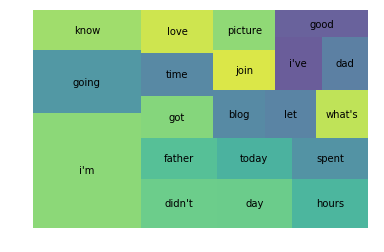

In [73]:
wc = count(df['tokens'])
wc_top20= wc[wc['rank'] <=20]

import squarify
squarify.plot(sizes=wc_top20['pct_total'],label=wc_top20['word'],alpha=.8)
plt.axis('off')
plt.show()

In [75]:
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
62,i'm,11,20,1.0,0.020141,0.020141,0.647059
20,going,9,11,2.0,0.011078,0.031219,0.529412
13,know,5,7,3.0,0.007049,0.038268,0.294118
83,didn't,5,6,4.0,0.006042,0.044310,0.294118
138,day,3,6,5.0,0.006042,0.050352,0.176471
272,hours,4,6,6.0,0.006042,0.056395,0.235294
116,father,1,5,7.0,0.005035,0.061430,0.058824
260,today,4,5,8.0,0.005035,0.066465,0.235294
214,spent,3,5,9.0,0.005035,0.071501,0.176471
245,got,4,5,10.0,0.005035,0.076536,0.235294


In [0]:
stop_words3=nlp.Defaults.stop_words.union(['blog',"i'm","I'm","$i'm",'i\'m','I\'m'])
stop_words3
#I tried double quotes and I've tried escaping the single quote but i'm is still rank one.

In [0]:
ignore = ['<','>','=','\\','|','||','/','\n',' ']
tokens=[]

for row in tokenizer.pipe(df['Post'],batch_size=500):
  row_tokens=[]
  for token in row:
    if (token.is_stop==False) and (token.is_punct==False) and (token.text not in stop_words3):
      word = True
      for char in ignore:
        if char in token.text:
          word = False
          break
      if word:
        row_tokens.append(token.text.lower())
  tokens.append(row_tokens)
  
df['tokens']=tokens
wc=count(df['tokens'])
wc.head()

## Stretch Goals

* Write a web scraper that can scrape "Data Scientist" job listings from indeed.com.
* Look ahead to some of the topics from later this week:
 - Part of Speech Tagging
 - Named Entity Recognition
 - Document Classification
* Try a different visualization techniques
* Automate the process of retriving job listings. ;)